# <font color=#770000>ICPE 639 Introduction to Machine Learning </font>

## ------ With Energy Applications

Some of the examples and exercises of this course are based on several books as well as open-access materials on machine learning, including [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)


<p> &#169; 2021: Xiaoning Qian </p>

[Homepage](http://xqian37.github.io/)

**<font color=blue>[Note]</font>** This is currently a work in progress, will be updated as the material is tested in the class room.

All material open source under a Creative Commons license and free for use in non-commercial applications.

Source material used under the Creative Commons Attribution-NonCommercial 3.0 Unported License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc/3.0/ or send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

# Non-parametric (Instance-based) Models

Here we cover some simple but interpretable (**white-box** compared to **black-box** deep neural networks covered later) and often nonlinear models. This section will cover the content listed below: 

- [1 Decision Tree](#1-Decision-Trees)
- [2 Random Forests](#2-Random-Forests)
- [3 K-Nearest-Neighbors](#3-K-Nearest-Neighbors)
- [4 Hands-on Exercise](#4-Hands-on-Exercise)
- [Reference](#Reference) 



In [1]:
# required modules
import pandas as pd
import numpy as np
import six
import sys
sys.modules['sklearn.externals.six'] = six
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text, plot_tree
from sklearn.externals.six import StringIO
import pydot
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Image

## 1 Decision Trees 

* Basics
  - A simple example
  - CART: visualization, algorithm, tree pruning.
* a real-world data example


### 1.1 Basics

The argubably most popular decision tree models is **CART** (Classification and Regression Tree). The basic idea is to derive *recursive partitions* given a training data set. There are different extensions based on the recursive partitioning idea. For CART, the partitions is derived by finding the corresponding input feature and threshold value to divide the input domain or "predictor space" recursively. The procedure is often iterative and then regularization can be done for example by post-processing pruning. 

**<font color=blue>[Note]</font>** There have been recent optimal decision tree methods by casting the training problem as integer programming (IP) optimization formulations. 

#### A simple example of decision tree



In [2]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

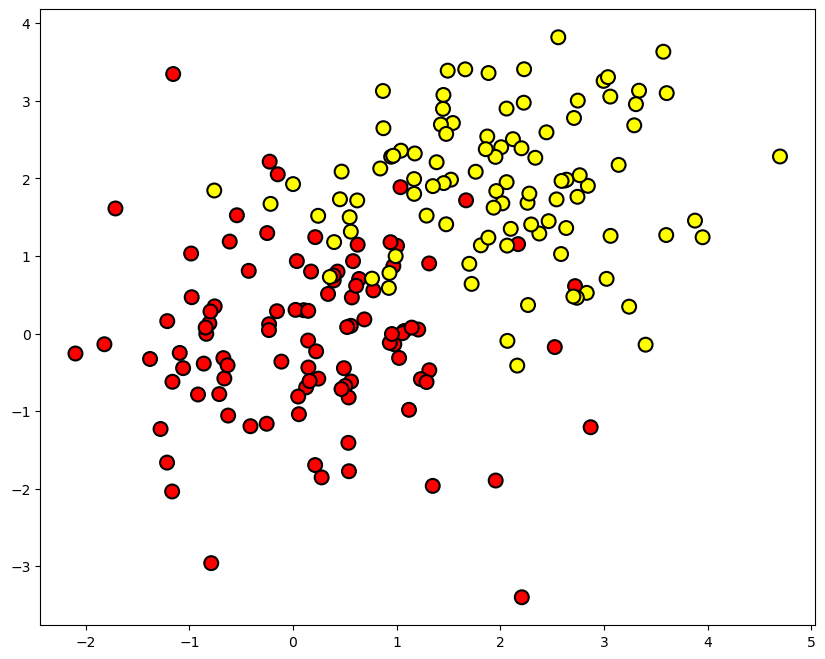

In [3]:
# visualize the two classes
plt.figure(figsize=(10, 8))
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
)

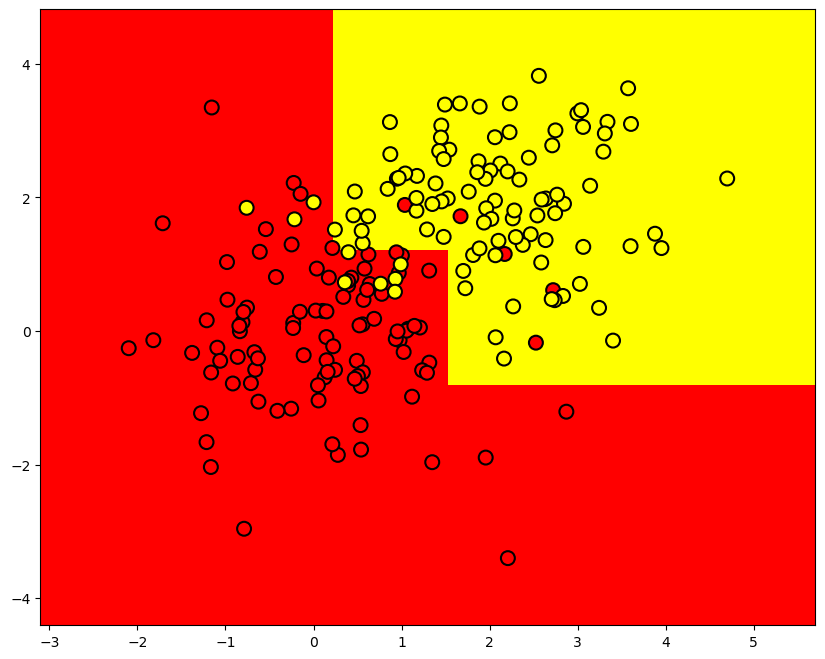

In [4]:
# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=17)

# training the tree
clf_tree.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
);

### 1.2 Components of a tree
* Node: a point in the tree between two branches
* Root Node: the first node in the tree
* Branches: arrow connecting one node to another
* Leaf node: a final nodel in the tree
* Level: 1 + the number of connections between the node and the root
* Branching factor: the number of children at each node, the outdegree



### 1.3 Algorithmic details of decision trees

#### Regression Tree

  1. (**Training**) Divide the predictor space—that is, the set of possible values for $X_1, X_2, \dots , X_P$—into J distinct and non-overlapping partitions or regions, $R_1,R_2,\dots,R_J$.
  2. (**Testing**) For every observation that falls into the region $R_j$ , we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$.
  

 
### The process of building a regression tree

* For training, how to construct the regions $R_1,\dots,R_J$? Divide the predictor space into high-dimensional rectangles, or boxes, for simplicity and for ease of interpretation of the resulting predictive model. The goal is to find boxes $R_1, \dots , R_J$ that minimize the RSS, given by $\sum_{j=1}^J \sum_{i\in R_j}(y_i - \widehat{y}_{R_j})^2$.
  - **Recursive binary splitting**: successively splits the predictor space; each split is indicated via two new branches further down on the tree. Each splitting can be done (by exhausting or sampling) based on optimizing the following objective function to find the feature $X_p$ and corresponding threshold $x_p$: 
  
  $$ (p^*, x_{p^*}^*) = \arg\min_{p, x_p} {\{RSS_{left} + RSS_{right}\}}, $$
  where $RSS_{left}$ and $RSS_{right}$ denote the RSS for the training data belonging the corresponding two partitions given the selected feature index $p$ and threshold $x_p$. 
  


  
**<font color=blue>[Note]</font>** There are variations to the above objective function in implementation. For example, these can be further weighted by the number of training data assigned to each region. 


**<font color=blue>[Note]</font>** As stated earlier, there are more complicated ways to construct decision trees. For example, ID3 (Iterative Dichotomiser 3) iteratively gets more than two partitions / regions. 


#### Classification Tree
A classification tree is very similar to a regression tree, except that it is used to predict a qualitative response rather than a quantitative one.

In the classification setting, RSS cannot be used as a criterion for making the binary splits. A natural alternative to RSS is the classification error rate: $E = 1 - \max_k (\widehat{p}_{mk})$, where $\widehat{p}_{mk}$ represents the proportion of training observations in the $m$th region that are from the $k$th class.

In practice, two other measures, as **impurity** measures, are preferable: 
  - **Gini index**: $G = \sum_{k=1}^K \widehat{p}_{mk}(1-\widehat{p}_{mk})$,
  - **Entropy**: $D = -\sum_{k=1}^K \widehat{p}_{mk} \log \widehat{p}_{mk}$.



#### Tree pruning & Regularization

The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits (that is, fewer regions $R_1,\dots,R_J$) might lead to lower variance and better interpretation at the cost of a little bias.

One possible solution is to regularize the tree growing process by constrain the tree depth or node size for example. 

The better strategy is to grow a very large tree $T_0$, and then prune it back in order to obtain a subtree by checking the statistical significance of each node's prediction. If either the RSS is high or impurity score is not good for classification discussed below, the node can be deleted (merged to its parent node).  `Cross validation` is one way to prune the tree.


### 1.4 An Application to Heart Data

#### Background
* `Heart` dataset contains a binary outcome `HD` for 303 patients who presented with chest pain. An outcome value of `Yes` indicates the presence of heart disease based on an angiographic test, while `No` means no heart disease. 

* There are 13 predictors including `Age`, `Sex`, `Chol` (a cholesterol measurement), `Thal`( Thallium stress test) and other heart and lung function measurements. 


In [5]:
Heart = pd.read_csv('https://raw.githubusercontent.com/XiaomengYan/MachineLearning_dataset/main/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
Heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        297 non-null    int64  
 1   Sex        297 non-null    int64  
 2   ChestPain  297 non-null    object 
 3   RestBP     297 non-null    int64  
 4   Chol       297 non-null    int64  
 5   Fbs        297 non-null    int64  
 6   RestECG    297 non-null    int64  
 7   MaxHR      297 non-null    int64  
 8   ExAng      297 non-null    int64  
 9   Oldpeak    297 non-null    float64
 10  Slope      297 non-null    int64  
 11  Ca         297 non-null    float64
 12  Thal       297 non-null    object 
 13  AHD        297 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


In [6]:
Heart.ChestPain = pd.factorize(Heart.ChestPain)[0]
Heart.Thal = pd.factorize(Heart.Thal)[0]
X2 = Heart.drop('AHD', axis=1) # explanatory variables
y2 = pd.factorize(Heart.AHD)[0] # response variables AHD

In [7]:
clf = DecisionTreeClassifier(ccp_alpha=0.0150, max_depth=None, max_leaf_nodes=3, max_features=3)
clf.fit(X2,y2)

DecisionTreeClassifier(ccp_alpha=0.015, max_features=3, max_leaf_nodes=3)

In [8]:
clf.score(X2,y2) #Return the mean accuracy on the given data and labels.

0.7474747474747475

In [ ]:
# This function creates images of tree models using pydot
# def print_tree(estimator, features, class_names=None, filled=True):
#     tree = estimator
#     names = features
#     color = filled
#     classn = class_names
    
#     dot_data = StringIO()
#     export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
#     graph = pydot.graph_from_dot_data(dot_data.getvalue())
#     return(graph)

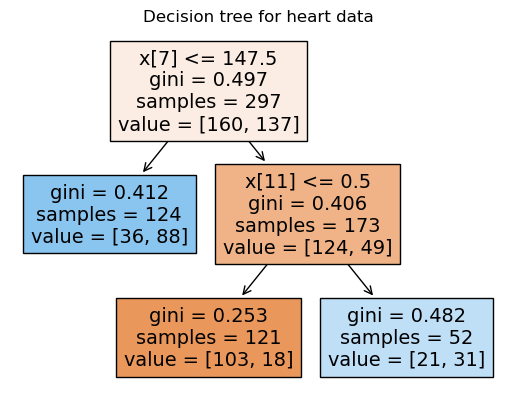

In [10]:
# graph2, = print_tree(clf, features=X2.columns, class_names=['No', 'Yes'])
# Image(graph2.create_png())

plt.figure()
plot_tree(clf, filled=True)
plt.title("Decision tree for heart data")
plt.show()

## 2 Random forests

Random forest is a state-of-the-art method for supervised learning, which builds multiple decision trees and merges them together to get a more accurate and stable prediction. It provides an improvement over Bagged trees for a large number of predictors. It uses a small tweak (**bagging**) that decorrelates the predictors.

The general idea of the bagging method is that a combination of tree models enhance the overall prediction performance.

Additional randomness is added to the model while trees grow.  

* Random forests: Basic algorithm (as ensemble ML methods)
* A real-world example (compared with decision trees)




### 2.1 Algorithm


Take classification to illustrate the algorithmic procedure. Random forest grows many classification trees. 

Each tree is grown as follows: Assume the number of cases in the training set is $N$, and the number of variables is $M$, 

1. Sample $N$ cases at random with replacement (bootstrap) from the original training data. 

2. Each time a split in a tree is considered, a random sample of $m$ predictors is chosen as split candidates from the full set of $M$ predictors. $m$ is fixed during the forest growing. The split is allowed to use only one of those $m$ predictors.


To classify a new test input, each tree gives a classification and the majority voting over all the trees in the forest is the final prediction. 

It is shown that the forest error rate depends on:
* The correlation between any two trees in the forest, increasing the correlation increases the forest error rate.
* The strength of each individual tree in the forest. Increaing the strength of the individual trees decreases the forest error rate.


### 2.2 Random Forests vs Decision Trees

* Random forest is a set of multiple decision trees.
* Deep decision trees may suffer from overfitting, but random forests prevent overfitting by creating trees on random subsets.
* Decision trees are computationally faster.
* Random forest is difficult to interpret, while a decision tree is easily interpretable and can be converted to *rules*.


**<font color=blue>[Note]</font>** **Bootstrapping**, **boosting**, and **bagging** 

* Bootstrapping: a resampling method, sampling with replacement. It's often used in estimation.
* Boosting: an ensemble method for improving the model predictions. The idea is to train weak learners sequentially, each trying to correct its predecessor. When an input is misclassified, its contribution to the training loss is increased so that it's more likely to be classified correctly. Models in boosting are related to the previous derived models. (<font color=blue>Basic boosting methods will be covered in a latter module.</font>)
* Bagging: (Bootstrap Aggregating) a machine learning ensemble strategy to improve performance, which uses bootstrap to get samples from the original training data, builds the models on each sampled dataset, and aggregates the results of all the models. Bagging can be parallelized as models are trained by different bootstrapped samples. 

### 2.3 Application with Decision Trees and Random Forests


#### Iris Data 

In [11]:
from sklearn import datasets

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [12]:
#Load dataset
iris = datasets.load_iris()

data=pd.DataFrame({
    'sepal length':iris.data[:,0],
    'sepal width':iris.data[:,1],
    'petal length':iris.data[:,2],
    'petal width':iris.data[:,3],
    'species':iris.target
})
data.head()

X=data[['sepal length', 'sepal width', 'petal length', 'petal width']]  # Features
y=data['species']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [13]:
#Create Classifier
clf = RandomForestClassifier(n_estimators=100)
clf2 = DecisionTreeClassifier(criterion="entropy",max_depth=3)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)
clf2.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_pred2 = clf2.predict(X_test)

# the accuracy of decision tree prediction
print("Accuracy of decision tree prediction = ",accuracy_score(y_test,y_pred2))

# the accuracy of random forest prediction
print("Accuracy of random forest prediction = ", accuracy_score(y_test,y_pred))

Accuracy of decision tree prediction =  0.9333333333333333
Accuracy of random forest prediction =  0.9555555555555556


#### Heart data

In [14]:
Heart.ChestPain = pd.factorize(Heart.ChestPain)[0]
Heart.Thal = pd.factorize(Heart.Thal)[0]
X2 = Heart.drop('AHD', axis=1) # explanatory variables
y2 = pd.factorize(Heart.AHD)[0] # response variables AHD

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3) # 70% training and 30% test

#Create Classifier
clf = RandomForestClassifier(n_estimators = 100, max_depth = 3)
clf2 = DecisionTreeClassifier(criterion = "entropy",max_depth = 3)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)
clf2.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_pred2 = clf2.predict(X_test)

# the accuracy of decision tree prediction
print("Accuracy of decision tree prediction = ", accuracy_score(y_test,y_pred2))
# the accuracy of random forest prediction
print("Accuracy of random forest prediction = ", accuracy_score(y_test,y_pred))

Accuracy of decision tree prediction =  0.7555555555555555
Accuracy of random forest prediction =  0.7777777777777778


## 3 K-nearest-neighbors

* Basics
     - A naive example
     - K-nearest-neighbor(KNN) algorithm illustration
     - Theory
     
* a real-world example


### 3.1 Basics

The nearest neighbors method (k-Nearest-Neighbors, or k-NN) is a very popular classification method. The method follows the compactness hypothesis: if the distance between the examples is measured well enough, then similar examples are much more likely to belong to the same class.

### A naive example

In [15]:
# simulated data in two-dimensional space
X = [[0,1], [1,1], [2,1], [3,2]]
y = [0, 0, 1, 1] #label
neigh = neighbors.KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

print(neigh.predict([[1.1,1.2]]))

print(neigh.predict_proba([[0.9,0.5]]))

[0]
[[0.66666667 0.33333333]]


### 3.2 Theoretical background of k-nearest-neighbor

* K-nearest-neighbors (KNN) is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions). Similarly as in decision trees, this can be extended to regression problems. 

* `Algorithm`: A case is classified by a majority vote of its neighbors, with the case being assigned to the class that is the most common amongst its K nearest neighbors measured by a distance function. If K = 1, then the case is simply assigned to the class of its nearest neighbor.

  1. Given a positive integer K and a test observation $x_0$, the KNN classifier first identifies the K points in the training data that are closest to $x_0$, represented by $\mathcal{N_0}$. 
  2. It then estimates the conditional probability for class $j$ as the fraction of points in $\mathcal{N_0}$ whose response values equal $j$: 
$$
P(Y = j|X = x_0) = \frac{1}{K}\sum_{i\in \mathcal{N_0}}I(y_i = j)
$$
  3. Finally, KNN classifies the test observation $x_0$ with the largest probability. 

* How to select the number of neighbors $k$: cross-validation.




#### Theorem

Let $e_{nn}$ denote the classification error of 1NN and $e_{Bayes} = \mathbb{E}_x\big[\min\{Pr(Y=1|X=x), Pr(Y=0|X=x)\}\big]$ denote the Bayes error for binary classification. If $Pr(Y=1|X=x) = f(x)$ is a $c$-Lipshitz function of $x$, we have
$$e_{Bayes} \leq e_{nn} \leq 2e_{Bayes} + c$$



#### Pros of knn method:

* Simple implementation
* Easy interpretability
* Well studied

**<font color="blue">[Note]</font>** Computation can be problematic to compute distances to all the training data points. The solutions can be either **tree**- or **hashing**-based indexing (computer science). 


### 3.3 An application to Iris data

In [16]:
iris = datasets.load_iris()
iris_data = pd.DataFrame({
    'sepal length':iris.data[:,0],
    'sepal width':iris.data[:,1],
    'petal length':iris.data[:,2],
    'petal width':iris.data[:,3],
    'species':iris.target
})
iris_data.head()

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Accuracy of knn prediction =  0.96


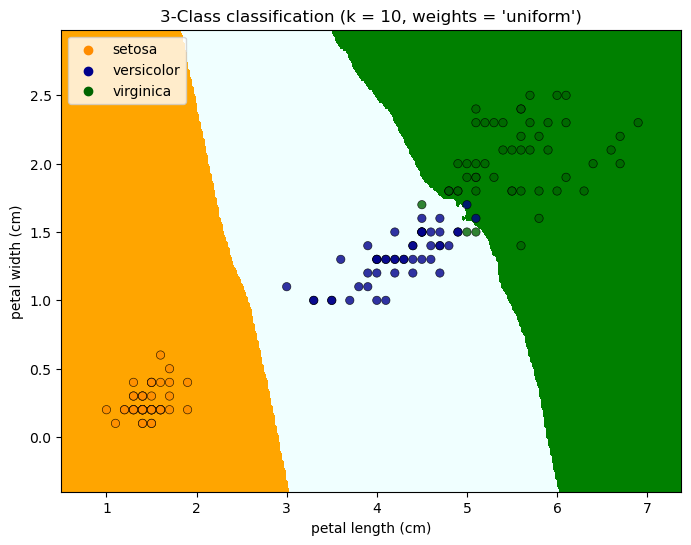

In [17]:
iris = datasets.load_iris()
X = iris.data[:, 2:4]
y = iris.target

n_neighbors = 10
h = .02  # step size in the mesh

cmap_light = ListedColormap(['orange', 'azure', 'green'])
cmap_bold = ['darkorange', 'darkblue', 'darkgreen']

weights='uniform'
    
# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights = weights)
clf.fit(X, y)

y_pred=clf.predict(X)
print("Accuracy of knn prediction = ", accuracy_score(y,y_pred))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min - 0.5, x_max + 0.5]x[y_min - 0.5, y_max + 0.5].
xx, yy = np.meshgrid(np.arange(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, h), np.arange(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap = cmap_light)

# Plot also the training points
sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = iris.target_names[y], palette = cmap_bold, alpha = 0.8, edgecolor = "black")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights))
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])

plt.show()

## 4 Hands on exercise: the MNIST Handwritten Digits Recognition

We use the `sklearn` built-in dataset on handwritten digits. This task is an example where k-NN works surprisingly well. 

Pictures here are 8x8 matrices (intensity of white color for each pixel). Then each such matrix is ​​"unfolded" into a vector of length 64, and we obtain a feature description of an object.


In [18]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target

X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

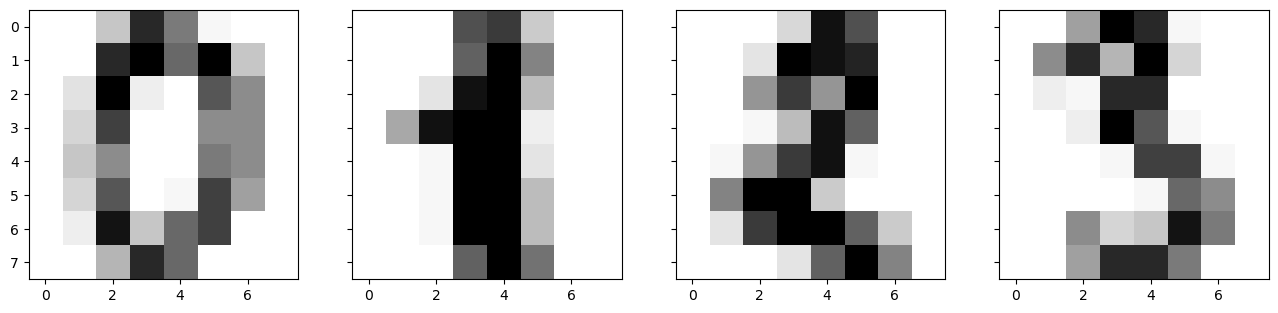

In [19]:
# visualization of the digits data: the 8x8 matrices.
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 6))
for i in range(4):
    axes[i].imshow(X[i, :].reshape([8, 8]), cmap="Greys");

In [20]:
# randomly select 70% of the data as training dataset, 30% as testing dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [21]:
# run the KNNclassifier on the training data, and select k = 10
# Create Classifier
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 5)
dtc = DecisionTreeClassifier(criterion = "entropy", max_depth = 5)
knn = neighbors.KNeighborsClassifier(n_neighbors = 20)

# Train the model using the training sets y_pred=clf.predict(X_test)
# predict on the testing data, and obtain the prediction accuracy
rfc.fit(X_train, y_train)
dtc.fit(X_train, y_train)
knn.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
dtc_pred = dtc.predict(X_test)
knn_pred = knn.predict(X_test)

# the accuracy of decision tree prediction
print("Accuracy of decision tree prediction = ", accuracy_score(y_test, dtc_pred))
# the accuracy of random forest prediction
print("Accuracy of random forest prediction = ", accuracy_score(y_test, rfc_pred))
# the accuracy of KNN prediction
print("Accuracy of KNN prediction = ", accuracy_score(y_test,knn_pred))

Accuracy of decision tree prediction =  0.7574074074074074
Accuracy of random forest prediction =  0.9296296296296296
Accuracy of KNN prediction =  0.9611111111111111


## Reference 
* [Random Forests by Leo Breiman and Adele Cutler](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm)
* [A quick guide to boosting in Machine Learning](https://medium.com/greyatom/a-quick-guide-to-boosting-in-ml-acf7c1585cb5)
* [A Primer to Ensemble Learning – Bagging and Boosting](https://analyticsindiamag.com/primer-ensemble-learning-bagging-boosting/)

# Questions? 

In [ ]:
Image(url= "https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png", width=100)
